In [ ]:
import os
import shutil
import os
 
# get current directory
cwd = os.getcwd()
parent = os.path.dirname(cwd)
parent = os.path.dirname(parent)

src_folder = parent + '\\Generation\\runs\\' 
dst_folder = './src/'
print(src_folder)
print(dst_folder)

# Copy all files from src_folder to dst_folder
for file_name in os.listdir(src_folder):
    shutil.copy(src_folder + file_name, dst_folder)

In [49]:
exp_name = 'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java'
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
!python convert_to_pre_eval.py --source_file $sf --target_dir $td


Done.



100%|██████████| 15800/15800 [00:00<00:00, 987512.71jsonline/s]


In [ ]:
# import subprocess
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"


# # subprocess.run(eval_cmd, shell=True)
print("### EVALUATION COMMAND ###")
print('#',eval_cmd)
print("### EVALUATION COMMAND ###")


In [ ]:
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java:/tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java:rw multipl-e-eval --dir /tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java --output-dir /tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java --recursive
### EVALUATION COMMAND ###

In [ ]:
# exp_name = 'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_800_humaneval_java'
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
target_dir = f'{td}'
output_file = f'res/{exp_name}_results.json'
!python pass_k.py $target_dir --output $output_file

#### Visualize the results

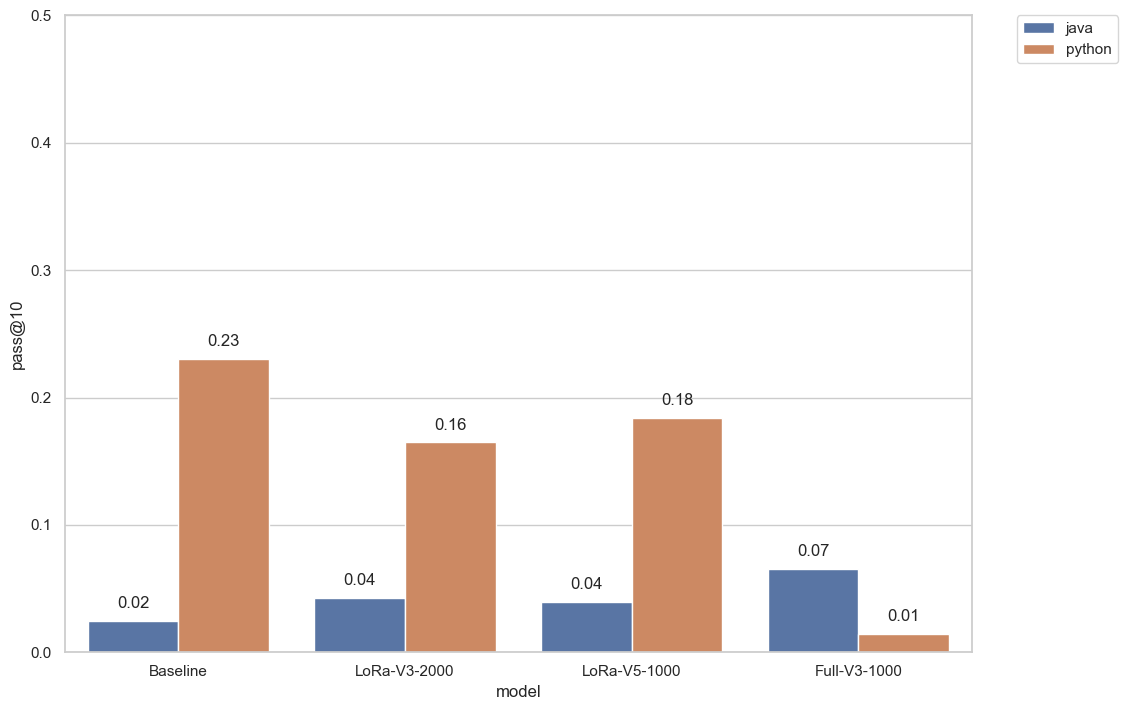

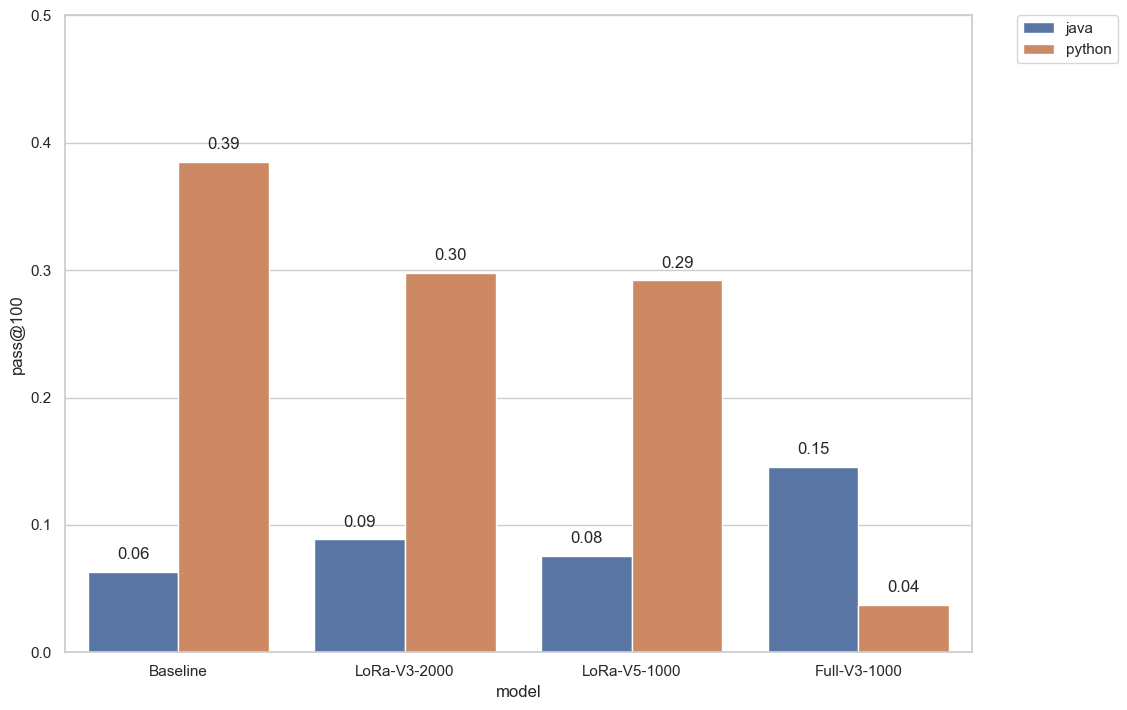

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


#get all the results files in the res folder
results_files = [f for f in os.listdir('res') if os.path.isfile(os.path.join('res', f))]

#load all the results files into a dictionary
results = {}
for f in results_files:
    with open(os.path.join('res', f)) as json_file:
        results[f] = json.load(json_file)
['Baseline', 'LoRa-V3-2000',
       'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java',
       'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py',
       'Full-V3-1000']
#Models Short Names
model_names_dict = {
    'codegen_350M_mono_humaneval_py': 'Baseline',
    'codegen_350M_mono_humaneval_java': 'Baseline',

    'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py': 'LoRa-V3-2000',
    'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java': 'LoRa-V3-2000',

    'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java': 'LoRa-V5-1000',
    'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py': 'LoRa-V5-1000',

    'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py': 'Full-V3-1000',
    'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java': 'Full-V3-1000'
}


#Merge all the results into a single dataframe
dict_df = {
    'model': [],
    'dataset': [],
    'pass@10': [],
    'pass@100': [],
    'num_problems': [],
    'min_completions': [],
    'max_completions': [],
    'programming_language': []
}

for model in results.keys():
    model_results = results[model]
    model_name = model.split('_results.json')[0]
    if model_name in model_names_dict.keys():
        model_name = model_names_dict[model_name]
    dataset_name = model_results['pass@10']['dataset']
    pass_10 = model_results['pass@10']['estimate']
    pass_100 = model_results['pass@100']['estimate']
    num_problems = model_results['pass@10']['num_problems']
    min_completions = model_results['pass@10']['min_completions']
    max_completions = model_results['pass@10']['max_completions']
    if 'humaneval_py' in dataset_name:
        programming_language = 'python'
    elif 'humaneval_java' in dataset_name:
        programming_language = 'java'
    else:
        programming_language = 'unknown'
    dict_df['model'].append(model_name)
    dict_df['dataset'].append(dataset_name)
    dict_df['pass@10'].append(pass_10)
    dict_df['pass@100'].append(pass_100)
    dict_df['num_problems'].append(num_problems)
    dict_df['min_completions'].append(min_completions)
    dict_df['max_completions'].append(max_completions)
    dict_df['programming_language'].append(programming_language)

df = pd.DataFrame(dict_df)

#Drop the dataset column
df = df.drop(columns=['dataset'])

#Drop the min_completions and max_completions columns
df = df.drop(columns=['min_completions', 'max_completions'])

#Drop the num_problems column
# df = df.drop(columns=['num_problems'])

#Plot the results
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="model", y="pass@10", hue="programming_language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 0.5
plt.ylim(0, 0.5)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#plot the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#Plot the results
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="model", y="pass@100", hue="programming_language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 0.5
plt.ylim(0, 0.5)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#plot the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



In [6]:
df[df['programming_language'] == 'java']

,model,pass@10,pass@100,num_problems,programming_language
0,Baseline,0.024779,0.063291,158,java
2,LoRa-V3-2000,0.042870,0.088608,158,java
4,LoRa-V5-1000,0.039309,0.075949,158,java
6,Full-V3-1000,0.065599,0.145570,158,java


### ALL FLOW

In [4]:
import os
import shutil
import subprocess

 
# get current directory
cwd = os.getcwd()
parent = os.path.dirname(cwd)
parent = os.path.dirname(parent)

src_folder = parent + '\\Generation\\runs\\' 
dst_folder = './src/'

# Copy all files from src_folder to dst_folder
for file_name in os.listdir(src_folder):
    shutil.copy(src_folder + file_name, dst_folder)


#Loop over all the files in the src folder and get the experiment names to run
for file_name in os.listdir(src_folder):
    exp_name = file_name.split('.jsonl')[0]
    #Print the experiment name
    print(f'Now running experiment: {exp_name}')

    #Convert the jsonl file to the pre-evaluation format
    sf = f'src/{exp_name}.jsonl'
    td = f'tgt/{exp_name.replace("-", "")}'
    print(f'Converting {sf} to {td}')
    !python convert_to_pre_eval.py --source_file $sf --target_dir $td
    print('Done!')

    #Run the evaluation
    print(f'Running evaluation on {td}')
    eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"
    # subprocess.run(eval_cmd, shell=True)
    print("### EVALUATION COMMAND ###")
    print('#',eval_cmd)
    print("### EVALUATION COMMAND ###")
    # print('Done!')

    #Run the pass@k
    print(f'Running pass@k on {td}')
    target_dir = f'{td}'
    output_file = f'res/{exp_name}_results.json'
    !python pass_k.py $target_dir --output $output_file
    print('Done!')

    

Now running experiment: codegen_350M_mono_humaneval_java
Converting src/codegen_350M_mono_humaneval_java.jsonl to tgt/codegen_350M_mono_humaneval_java
Done.
Done!
Running evaluation on tgt/codegen_350M_mono_humaneval_java
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegen_350M_mono_humaneval_java:/tgt/codegen_350M_mono_humaneval_java:rw multipl-e-eval --dir /tgt/codegen_350M_mono_humaneval_java --output-dir /tgt/codegen_350M_mono_humaneval_java --recursive
### EVALUATION COMMAND ###
Running pass@k on tgt/codegen_350M_mono_humaneval_java



100%|██████████| 15800/15800 [00:00<00:00, 929374.85jsonline/s]


Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
codegen_350M_mono_humaneval_java,10,0.024778887856673582,158,100,100
codegen_350M_mono_humaneval_java,100,0.06329113924050633,158,100,100
Saved results to res/codegen_350M_mono_humaneval_java_results.json
Done!
Now running experiment: codegen_350M_mono_humaneval_py
Converting src/codegen_350M_mono_humaneval_py.jsonl to tgt/codegen_350M_mono_humaneval_py
Done.
Done!
Running evaluation on tgt/codegen_350M_mono_humaneval_py
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegen_350M_mono_humaneval_py:/tgt/codegen_350M_mono_humaneval_py:rw multipl-e-eval --dir /tgt/codegen_350M_mono_humaneval_py --output-dir /tgt/codegen_350M_mono_humaneval_py --recursive
### EVALUATION COMMAND ###
Running pass@k on tgt/codegen_350M_mono_humaneval_py



100%|██████████| 16100/16100 [00:00<00:00, 805115.94jsonline/s]


Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
codegen_350M_mono_humaneval_py,10,0.2302780351168523,161,100,100
codegen_350M_mono_humaneval_py,100,0.38509316770186336,161,100,100
Saved results to res/codegen_350M_mono_humaneval_py_results.json
Done!
Now running experiment: codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java
Converting src/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java.jsonl to tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java
Done.
Done!
Running evaluation on tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java:/tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java:rw multipl-e-eval --dir /tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java --output-dir /tgt/codegne_finetune


100%|██████████| 15800/15800 [00:00<00:00, 729026.90jsonline/s]


Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java,10,0.042869639377974326,158,100,100
codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java,100,0.08860759493670886,158,100,100
Saved results to res/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java_results.json
Done!
Now running experiment: codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py
Converting src/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py.jsonl to tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py
Done!Done.

Running evaluation on tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py:/tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py:rw multipl-e-eval --di


100%|██████████| 16100/16100 [00:00<00:00, 764907.11jsonline/s]


Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py,10,0.1648836398716885,161,100,100
codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py,100,0.2981366459627329,161,100,100
Saved results to res/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py_results.json
Done!
Now running experiment: codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java
Converting src/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java.jsonl to tgt/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java
Done!
Running evaluation on tgt/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java:/tgt/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java:rw multipl-e-eval --dir /


100%|██████████| 15800/15800 [00:00<00:00, 829401.42jsonline/s]


Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java,10,0.03930863023179068,158,100,100
codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java,100,0.0759493670886076,158,100,100
Saved results to res/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java_results.json
Done!
Now running experiment: codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py
Converting src/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py.jsonl to tgt/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py
Done.
Done!
Running evaluation on tgt/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py:/tgt/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py:rw multipl-e-eval --dir 


100%|██████████| 16100/16100 [00:00<00:00, 711813.20jsonline/s]


Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py,10,0.1838872764484975,161,100,100
codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py,100,0.2919254658385093,161,100,100
Saved results to res/codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py_results.json
Done!
Now running experiment: codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java
Converting src/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java.jsonl to tgt/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java
Done.
Done!
Running evaluation on tgt/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java:/tgt/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java:rw multipl-e-eval --dir /tgt/codegne_finetuned_th


100%|██████████| 15800/15800 [00:00<00:00, 850040.45jsonline/s]


Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java,10,0.0655987000786756,158,100,100
codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java,100,0.14556962025316456,158,100,100
Saved results to res/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java_results.json
Done!
Now running experiment: codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py
Converting src/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py.jsonl to tgt/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py
Done.
Done!
Running evaluation on tgt/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py:/tgt/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py:rw multipl-e-eval --dir /tgt/codegne_finetuned_the_stack_java_v3_chec


100%|██████████| 16100/16100 [00:00<00:00, 868620.49jsonline/s]


Dataset,Pass@k,Estimate,NumProblems,MinCompletions,MaxCompletions
codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py,10,0.014518599904971922,161,100,100
codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py,100,0.037267080745341616,161,100,100
Saved results to res/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py_results.json
Done!


# Error Analysis

In [38]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})



# Function to get all the statuses from a list of results
def get_all_statuses(results):
    all_statuses = []
    for result in results:
        all_statuses.append(result['status'])
    return all_statuses

# Function to get all statuses for all the results files in a tgt folder
def get_all_statuses_for_tgt_folder(tgt_folder):
    results_files = [f for f in os.listdir(tgt_folder) if os.path.isfile(os.path.join(tgt_folder, f)) and f.endswith('.results.json')]
    print(f'We have {len(results_files)} results files')
    all_statuses = {
        'results_file': [],
        'status': []
    }
    for results_file in results_files:
        with open(os.path.join(tgt_folder, results_file)) as json_file:
            data = json.load(json_file)
        results = data['results']
        statuses = get_all_statuses(results)
        all_statuses['results_file'].extend([results_file] * len(statuses))
        all_statuses['status'].extend(statuses)
    return all_statuses


#Function to plot the statuses for a tgt folder
def plot_statuses_for_tgt_folder(tgt_folder):
    all_statuses = get_all_statuses_for_tgt_folder(tgt_folder)
    df = pd.DataFrame(all_statuses)
    ax = sns.countplot(x="status", data=df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 0.01,
                '{:1.2f}'.format(height),
                ha="center")
    plt.show()

#Function to put all the resluts from all folders into a single dataframe
def get_all_results_for_tgt_folder():
    root_folder = 'tgt'
    tgt_folders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]
    print(f'We have {len(tgt_folders)} tgt folders')
    root_df = {
        'results_folder': [],
        'results_file': [],
        'status': [],
    }
    for tgt_folder in tgt_folders:
        all_statuses = get_all_statuses_for_tgt_folder(os.path.join(root_folder, tgt_folder))
        root_df['results_file'].extend(all_statuses['results_file'])
        root_df['status'].extend(all_statuses['status'])
        root_df['results_folder'].extend([tgt_folder] * len(all_statuses['status']))
    return pd.DataFrame(root_df)




In [43]:
df = get_all_results_for_tgt_folder()

We have 12 tgt folders
We have 105 results files
We have 161 results files
We have 82 results files
We have 100 results files
We have 121 results files
We have 135 results files
We have 81 results files
We have 158 results files
We have 80 results files
We have 86 results files
We have 144 results files
We have 113 results files


In [45]:
df.results_folder.unique()

array(['codegen_350M_mono_humaneval_java',
       'codegen_350M_mono_humaneval_py',
       'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java',
       'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py',
       'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java',
       'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py',
       'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java',
       'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_800_humaneval_java',
       'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java',
       'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py',
       'codegne_finetuned_the_stack_java_v2_checkpoint_800_humaneval_java',
       'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java'],
      dtype=object)

In [46]:
# Drop results folders that we don't want to plot, we only want to plot these:
#[
#    'codegen_350M_mono_humaneval_py',
#    'codegen_350M_mono_humaneval_java',
#    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java',
#    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py',
# 'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py'
# 'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java'
# ]

df = df[df.results_folder.isin([
    'codegen_350M_mono_humaneval_py',
    'codegen_350M_mono_humaneval_java',
    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java',
    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py',
    'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py',
    'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java'
])]

In [52]:
# add language column to the dataframe, 
# if results_folder end with _py then language is python
# if results_folder end with _java then language is java
# else language is unknown

df['language'] = np.where(df['results_folder'].str.endswith('_py'), 'python', np.where(df['results_folder'].str.endswith('_java'), 'java', 'unknown'))

df_java = df[df.language == 'java']
df_python = df[df.language == 'python']

In [56]:
df.results_folder.value_counts()

codegen_350M_mono_humaneval_py                                            32200
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py      27000
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java    24200
codegen_350M_mono_humaneval_java                                          21000
codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py           17200
codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java        11300
Name: results_folder, dtype: int64

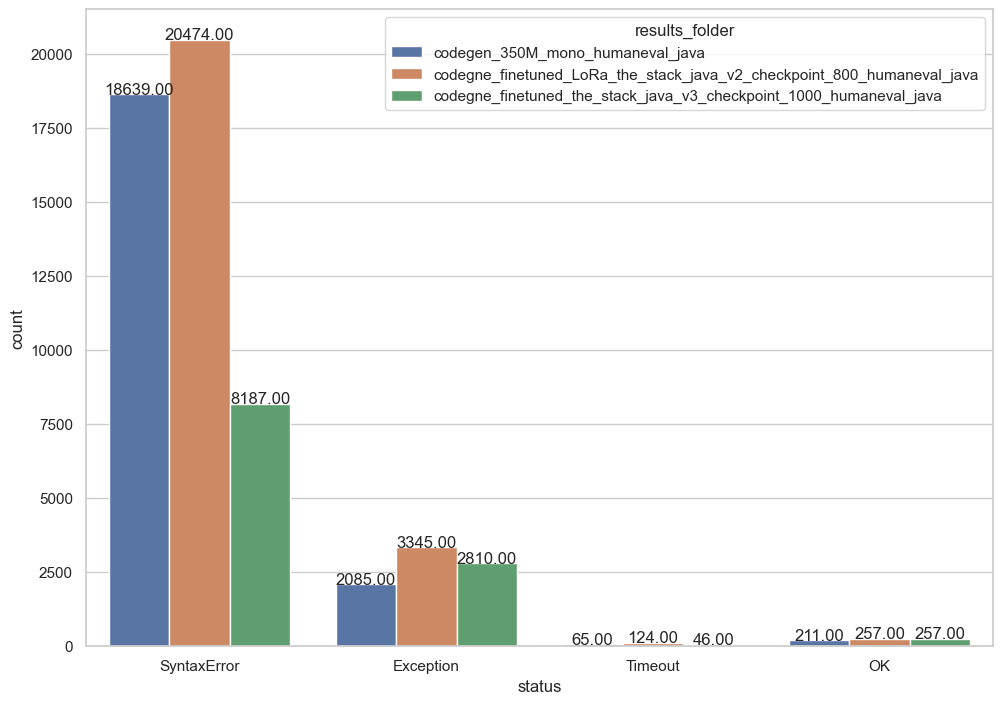

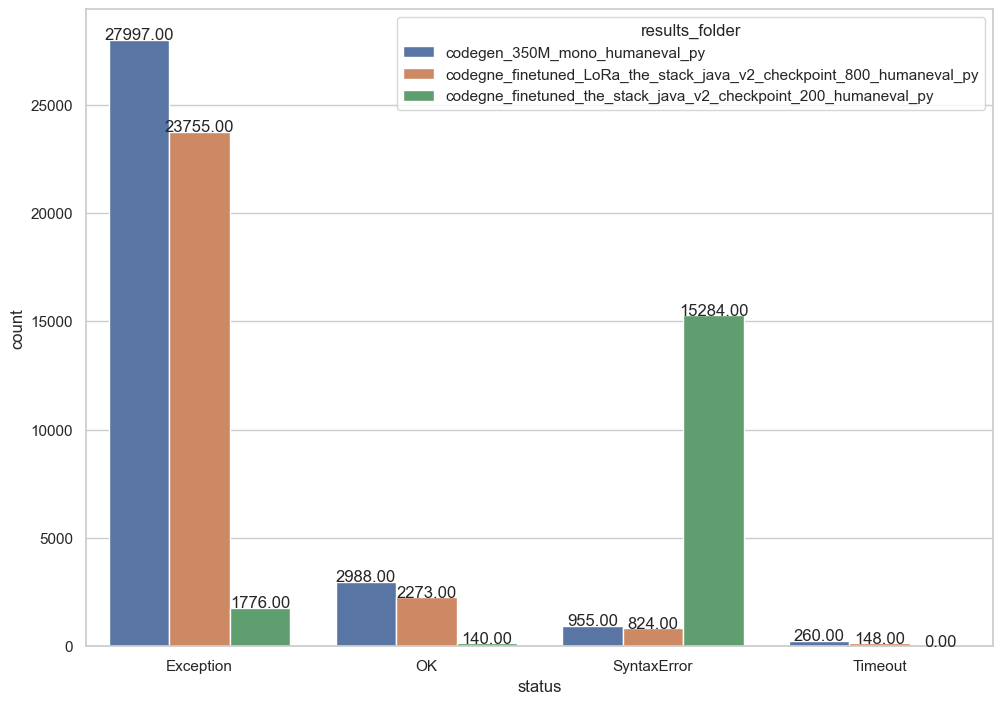

In [55]:


#Plot the statuses counts grouped by results folder
ax = sns.countplot(x="status", hue="results_folder", data=df_java)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
plt.show()




#Plot the statuses counts grouped by results folder
ax = sns.countplot(x="status", hue="results_folder", data=df_python)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#plot the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [41]:
df.results_folder.unique()

array(['codegen_350M_mono_humaneval_java',
       'codegen_350M_mono_humaneval_py',
       'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java',
       'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py',
       'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java',
       'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py',
       'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java',
       'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_800_humaneval_java',
       'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java',
       'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py',
       'codegne_finetuned_the_stack_java_v2_checkpoint_800_humaneval_java',
       'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java'],
      dtype=object)

In [21]:
#get all the folders in the tgt folder
tgt_folders = [f for f in os.listdir('tgt') if os.path.isdir(os.path.join('tgt', f))]
print(f'We have {len(tgt_folders)} tgt folders')
for tgt_folder in tgt_folders:
    print(tgt_folder)

We have 12 tgt folders
codegen_350M_mono_humaneval_java
codegen_350M_mono_humaneval_py
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_java
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_200_humaneval_py
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java
codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py
codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java
codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_800_humaneval_java
codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_java
codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py
codegne_finetuned_the_stack_java_v2_checkpoint_800_humaneval_java
codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java


We have 161 results files
We have 113 results files
We have 11300 results files in tgt/codegen_350M_mono_humaneval_py
We have 11300 results files in tgt/codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java


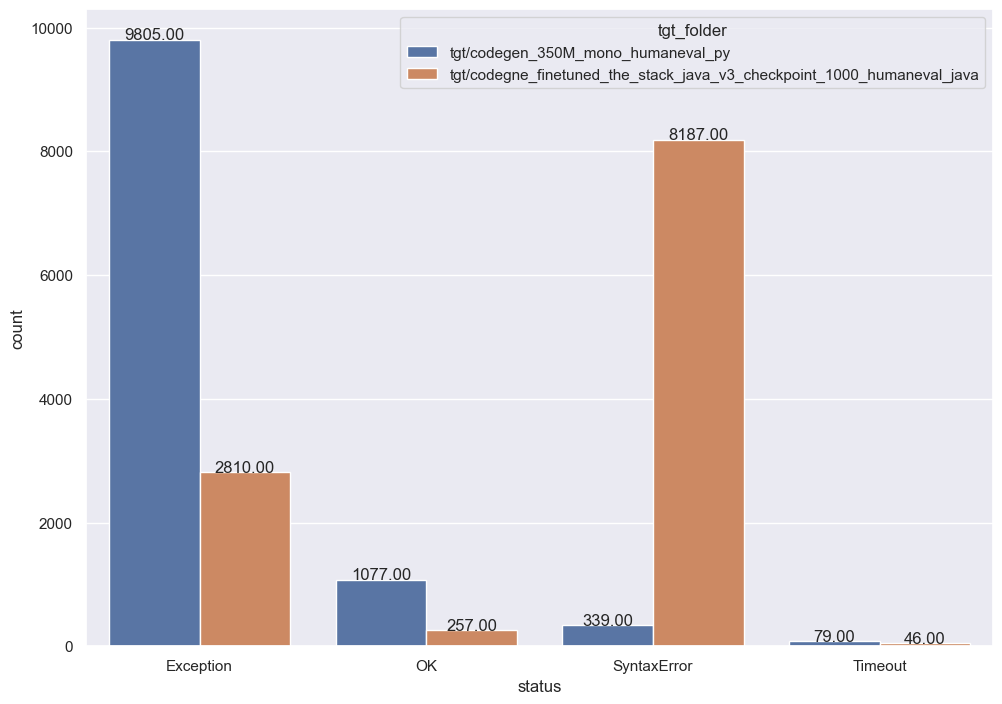

In [25]:
folder1 = 'codegen_350M_mono_humaneval_py'
folder2 = 'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java'
folder1 = 'tgt' + '/' + folder1
folder2 = 'tgt' + '/' + folder2
plot_statuses_for_two_tgt_folders(folder1, folder2)